# Data Cleaning

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import time


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pmd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from pykalman import KalmanFilter

The dataset comes pretty cleaned already. Only a few adjustments will be needed to make it more interpratable. 

In [2]:
data = pd.read_csv('Blue.csv')

data.shape

(69923, 6)

In [3]:
data.head()

,Unnamed: 0,StoreID,WkStart,Sales,CheckCount,DayCnt
0,0,100,2019-06-10,40489.83,4982,7
1,1,100,2019-06-17,39416.17,4934,7
2,2,100,2019-06-24,39528.15,4975,7
3,3,100,2019-07-01,44083.50,5219,7
4,4,100,2019-07-08,41579.67,4905,7


In [4]:
#Drop the Unnamed columns
data.drop(columns = ['Unnamed: 0'],inplace = True)

In [5]:
#Check for nulls
data.isna().sum()

StoreID       0
WkStart       0
Sales         0
CheckCount    0
DayCnt        0
dtype: int64

In [6]:
#Check for duplicated rows
print(data.duplicated().sum())

0


In [7]:
data.describe()

,StoreID,Sales,CheckCount,DayCnt
count,69923.000000,69923.000000,69923.000000,69923.000000
mean,15446.293737,30614.463112,2701.893297,6.865938
std,4844.399699,13332.000423,1266.123709,0.548202
min,100.000000,2.400000,1.000000,1.000000
25%,12879.000000,21011.930000,1826.500000,7.000000
50%,14547.000000,29801.460000,2558.000000,7.000000
75%,16781.000000,38784.838400,3373.000000,7.000000
max,27981.000000,167634.670000,17892.000000,7.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69923 entries, 0 to 69922
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     69923 non-null  int64  
 1   WkStart     69923 non-null  object 
 2   Sales       69923 non-null  float64
 3   CheckCount  69923 non-null  int64  
 4   DayCnt      69923 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.7+ MB


In [9]:
#Turn StoreID into an object
#WkStart into datetime

data.StoreID = data.StoreID.astype('O')
data.WkStart = pd.to_datetime(data.WkStart)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69923 entries, 0 to 69922
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   StoreID     69923 non-null  object        
 1   WkStart     69923 non-null  datetime64[ns]
 2   Sales       69923 non-null  float64       
 3   CheckCount  69923 non-null  int64         
 4   DayCnt      69923 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 2.7+ MB


# EDA

<AxesSubplot:>

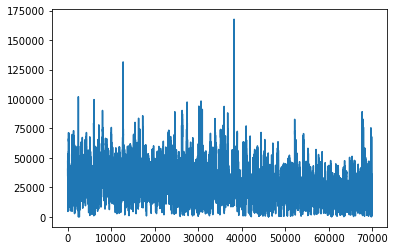

In [13]:
data.Sales.plot()

In [14]:
#Look at the different number of stores 

print('Number of unique stores: '+format(len(data.StoreID.unique())))
Counter(data.StoreID).most_common()

Number of unique stores: 716


[(3935, 105),
 (4330, 105),
 (4555, 105),
 (4833, 105),
 (5244, 105),
 (5245, 105),
 (5295, 105),
 (5298, 105),
 (5514, 105),
 (5827, 105),
 (6103, 105),
 (6118, 105),
 (6294, 105),
 (6344, 105),
 (6873, 105),
 (7121, 105),
 (7192, 105),
 (7723, 105),
 (7821, 105),
 (7868, 105),
 (7887, 105),
 (7889, 105),
 (7923, 105),
 (8022, 105),
 (8031, 105),
 (8088, 105),
 (8089, 105),
 (8090, 105),
 (8121, 105),
 (8178, 105),
 (8319, 105),
 (8549, 105),
 (8550, 105),
 (8572, 105),
 (8643, 105),
 (8687, 105),
 (9173, 105),
 (9178, 105),
 (9206, 105),
 (9228, 105),
 (9282, 105),
 (9505, 105),
 (9589, 105),
 (9600, 105),
 (10012, 105),
 (10076, 105),
 (10115, 105),
 (10116, 105),
 (10281, 105),
 (10288, 105),
 (10353, 105),
 (10354, 105),
 (10383, 105),
 (10395, 105),
 (10419, 105),
 (10542, 105),
 (10736, 105),
 (10742, 105),
 (10743, 105),
 (10744, 105),
 (10843, 105),
 (10931, 105),
 (10981, 105),
 (11065, 105),
 (11077, 105),
 (11078, 105),
 (11079, 105),
 (11080, 105),
 (11090, 105),
 (11296, 

<AxesSubplot:>

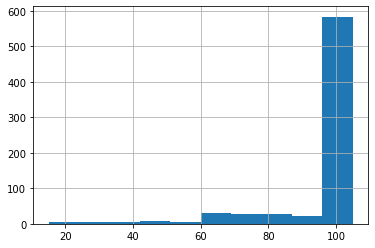

In [23]:
data.StoreID.value_counts().hist()

Majority of the stores have around 100 data points, there are quite a few that has too little data

Lets take a look at some of these stores and see what's happening

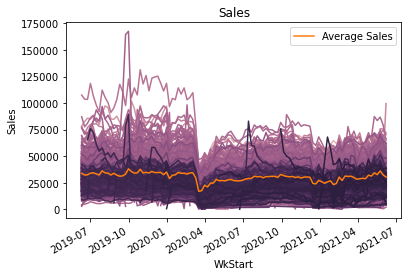

In [41]:
sns.lineplot(data=data
            ,x='WkStart'
            ,y='Sales'
            ,hue='StoreID'
            ,legend=False)

data.groupby(by='WkStart').mean()['Sales'].plot(label='Average Sales')

plt.title('Sales')
plt.legend()

plt.show()

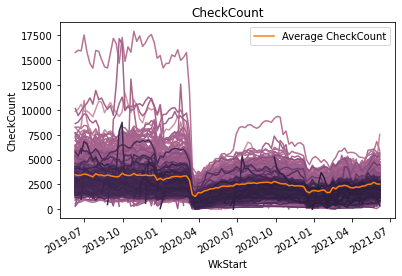

In [44]:
sns.lineplot(data=data
            ,x='WkStart'
            ,y='CheckCount'
            ,hue='StoreID'
            ,legend=False)

data.groupby(by='WkStart').mean()['CheckCount'].plot(label='Average CheckCount')

plt.title('CheckCount')
plt.legend()

plt.show()

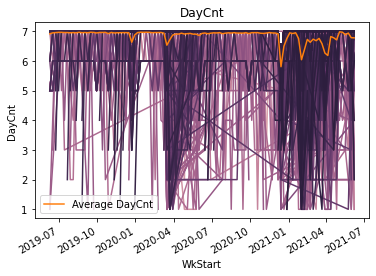

In [46]:
sns.lineplot(data=data
            ,x='WkStart'
            ,y='DayCnt'
            ,hue='StoreID'
            ,legend=False)

data.groupby(by='WkStart').mean()['DayCnt'].plot(label='Average DayCnt')

plt.title('DayCnt')
plt.legend()

plt.show()

Since the data is pretty cleaned already and we are only looking at a single feature in a time series, not much EDA is required

# Models 

We will only be looking at predictions on Sales using the mean squared error as scores.  But it is coded to be able to test against other features within a time series as well

In [91]:
#funciton to split time series into training, dev and test sets


def train_dev_test(data, dev_size=13, test_size=1):
    
    train_size = len(data) - dev_size - test_size
    
    train = data[:train_size]
    dev = data[train_size:train_size+dev_size]
    test = data[-test_size:]
    
    return (train, dev, test)

In [163]:
train, dev, test = train_dev_test(data)

In [164]:
train

,StoreID,WkStart,Sales,CheckCount,DayCnt
0,100,2019-06-10,40489.83,4982,7
1,100,2019-06-17,39416.17,4934,7
2,100,2019-06-24,39528.15,4975,7
3,100,2019-07-01,44083.50,5219,7
4,100,2019-07-08,41579.67,4905,7
...,...,...,...,...,...
69904,27981,2021-02-01,3783.07,284,1
69905,27981,2021-02-08,11415.90,833,3
69906,27981,2021-02-15,16179.40,1204,4
69907,27981,2021-02-22,8165.59,675,3


In [165]:
dev

C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,StoreID,WkStart,Sales,CheckCount,DayCnt
69909,27981,2021-03-08,25810.21,2059,7
69910,27981,2021-03-15,26693.28,2133,7
69911,27981,2021-03-22,24796.63,1984,7
69912,27981,2021-03-29,17857.98,1467,5
69913,27981,2021-04-05,21726.92,1698,6
69914,27981,2021-04-12,25213.20,2007,7
69915,27981,2021-04-19,23888.65,1930,7
69916,27981,2021-04-26,27600.97,2087,7
69917,27981,2021-05-03,25277.21,2059,7
69918,27981,2021-05-10,26978.77,2081,7


In [166]:
test

C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,StoreID,WkStart,Sales,CheckCount,DayCnt
69922,27981,2021-06-07,24310.67,2110,7


In [103]:
#Define function for calculating root mean squared error 

def RMSE(actual, pred):
    rmse = round(sqrt(mean_squared_error(actual, pred)),4) 
    return rmse

### First Model - Moving Average

In [94]:
#define function to perform MA modeling on given dataframe

def MA_Model(data,target,storeID):
    
    #Drop na
    dat = data[data['StoreID']==storeID]
    
    MA_df = pd.DataFrame()
    
    #set threshold to drop stores with low data count
    if len(dat)<50:
        data = data.drop(index=dat.index).dropna().reset_index(drop=True)
        print('Insufficient data for StoreID '+format(storeID))
        
    else:
        dat = dat.dropna().reset_index(drop=True)

        window_sizes=list(np.arange(2,int(len(dat)*0.5)) )

        #use train_dev_test to split
        tr,dev,te = train_dev_test(dat) 

        dev_rmse = []

        for W in window_sizes:
            history = tr[target].values
            dev_ = dev[target].values
            predictions = []

            for i in range(len(dev_)):
                window = history[-W:]
                pred = np.mean(window)
                predictions.append(pred)
                np.append(history,dev_[i])

            rmse = RMSE(dev_,predictions)
            dev_rmse.append(rmse)

        #now we have a list of dev_rmse and window sizes, select window size based on best dev_rmse

        best_dev_rmse = min(dev_rmse)
        windowX = window_sizes[dev_rmse.index(best_dev_rmse)]

        #find score on training set with window size

        tr_true = tr[target][windowX:]
        tr_pred = tr[target].rolling(windowX+1).mean().dropna()

        train_rmse = RMSE(tr_true,tr_pred)

        #now to score on the test set
        full_train = tr.append(dev)
        full_tr = full_train[target]
        full_tr_pred = full_tr.rolling(windowX).mean()[-1:]
        test_rmse = RMSE(te[target].values,full_tr_pred)

        #record scores
        MA_df = pd.DataFrame({'Model':'MA'
                              ,'Data_Set':['Train','Dev','Test']
                              ,'RMSE':[train_rmse,best_dev_rmse,test_rmse]
                              ,'Params':windowX})


    return MA_df


In [104]:
MA_Model(data=data,target='Sales',storeID=100)

,Model,Data_Set,RMSE,Params
0,MA,Train,9824.7178,17
1,MA,Dev,1619.2110,17
2,MA,Test,1081.5041,17


### Second Model - Linear Regression

In [95]:
def LR_Model(data,target,storeID, feature=['index']):
    
    #dropping na
    dat = data[data['StoreID']==storeID].dropna()
    
    LR_df = pd.DataFrame()
    
    if len(dat)<50:
        
        data = data.drop(index=dat.index).dropna().reset_index(drop=True).reset_index()
        print('Insufficient data for StoreID '+format(storeID))
    
    else:
        dat = dat.reset_index(drop=True).reset_index()
        
        #check to return target in list format
        if len(target)>1:
            target=[target]

        

        #use train_dev_test to split
        tr,dev,te = train_dev_test(dat)

        #split into train/test X's and y's
        X_tr = tr[feature].values.reshape(-1,len(feature))   
        y_tr = tr[target].values
        X_dev = dev[feature].values.reshape(-1,len(feature))
        y_dev = dev[target].values

        #Model
        LR_all_rmse = []
        best_rmse_score = np.inf
        LR_train_rmse = 0

        #parameters
        fit_intercept=[True,False]
        normalize=[True,False]
        copy_X=[True,False]
        n_jobs=[None,-1,1,3,5]

        #best params
        best_fit_intercept=None
        best_normalize=None
        best_copy_X = None
        best_n_jobs= None

        for a in fit_intercept:
            for b in normalize:
                for c in copy_X:
                    for d in n_jobs:
                        model = LinearRegression(fit_intercept =a
                                                 ,normalize = b
                                                 ,copy_X = c
                                                 ,n_jobs = d
                                                ).fit(X_tr,y_tr)
                        #tr_pred = model.predict(X_train)            #I could use this to finf train score, but this takes up extra time. Best to find score once best params are located
                        #tr_rmse = RMSE(train.Sales,tr_pred)
                        pred_ = model.predict(X_dev)                
                        rmse_ = RMSE(y_dev, pred_)        
                        LR_all_rmse.append(rmse_)  

                        if rmse_ < best_rmse_score:
                            best_rmse_score = rmse_
                            #LR_train_rmse = tr_rmse
                            best_fit_intercept= a
                            best_normalize= b
                            best_copy_X = c
                            best_n_jobs= d

        #Store best parameters

        LR_params = {'fit_intercept':best_fit_intercept
                     ,'normalize':best_normalize
                     ,'copy_X' : best_copy_X
                     ,'n_jobs': best_n_jobs}

        #score on training set
        tr_model = LinearRegression(**LR_params).fit(X_tr,y_tr)
        tr_pred = tr_model.predict(X_tr)
        tr_rmse = RMSE(tr[target],tr_pred)

        #full training set
        full_tr = tr.append(dev)

        #Using the full_train dataset, split into X's and y's
        X_tr2 = full_tr[feature].values.reshape(-1,len(feature))   
        y_tr2 = full_tr[target].values
        X_test = te[feature].values.reshape(-1,len(feature))   
        y_test = te[target].values

        #train and predict
        LR_test = LinearRegression(**LR_params).fit(X_tr2,y_tr2)
        LR_test_pred = LR_test.predict(X_test)

        #score
        LR_test_rmse = RMSE(y_test, LR_test_pred) 

        #store results

        LR_df = pd.DataFrame({'Model':'LR'
                              ,'Data_Set':['Train','Dev','Test']
                              ,'RMSE':[tr_rmse,best_rmse_score,LR_test_rmse]
                              ,'Params':[LR_params]*3})


        LR_df.reset_index(drop=True,inplace=True)

    return LR_df

In [105]:
LR_Model(data=data,target='Sales',storeID=100)

,Model,Data_Set,RMSE,Params
0,LR,Train,7945.0436,"{'fit_intercept': True, 'normalize': True, 'co..."
1,LR,Dev,7907.3956,"{'fit_intercept': True, 'normalize': True, 'co..."
2,LR,Test,8572.3632,"{'fit_intercept': True, 'normalize': True, 'co..."


### Model 3 - Polynomial Regression

In [96]:
#function to perform polynomial regression

def Poly_Regression(data,storeID,target,feature=['index'],degree=2):
    
    #dropping na
    dat = data[data['StoreID']==storeID].dropna()
    
    Poly_df = pd.DataFrame()
    
    #check to return target in list format
    if len(target)>1:
        target=[target]

    if len(dat)<50:  
        data = data.drop(index=dat.index)
        print('Insufficient data for StoreID '+format(storeID))
    
    else:
        dat = dat.reset_index(drop=True).reset_index()
        


        train_,dev_,test_ = train_dev_test(dat)

        X_train_ = train_[feature].values.reshape(-1,len(feature))
        y_train_ = train_[target].values
        X_dev_ = dev_[feature].values.reshape(-1,len(feature))
        y_dev_ = dev_[target].values

        #turn polynomial
        X_train_poly = PolynomialFeatures(degree=degree).fit_transform(X_train_)
        X_dev_poly = PolynomialFeatures(degree=degree).fit_transform(X_dev_)

        #model
        model = LinearRegression().fit(X_train_poly,y_train_)

        #predictions
        trend = model.predict(X_train_poly)
        dev_pred = model.predict(X_dev_poly)

        #scores on train/dev
        trend_rmse = RMSE(y_train_,trend)
        dev_rmse = RMSE(y_dev_,dev_pred)

        #now on the test set
        full_train_ = train_.append(dev_)

        X_ftrain = full_train_[feature].values.reshape(-1,len(feature))
        X_test_ = test_[feature].values.reshape(-1,len(feature))
        y_ftrain = full_train_[target].values
        y_test_ = test_[target].values

        X_ftrain_poly = PolynomialFeatures(degree=degree).fit_transform(X_ftrain)

        X_test_poly = PolynomialFeatures(degree=degree).fit_transform(X_test_)

        model2 = LinearRegression().fit(X_ftrain_poly,y_ftrain)

        test_pred = model2.predict(X_test_poly)

        test_rmse = RMSE(y_test_,test_pred)

        #store results
        Poly_df = pd.DataFrame({'Model':'D'+format(degree)
                                    ,'Data_Set':['Train','Dev','Test']
                                    ,'RMSE':[trend_rmse,dev_rmse,test_rmse]
                                    ,'Params':''})

    return Poly_df

In [108]:
Poly_Regression(data=data,target='Sales',storeID=100)

,Model,Data_Set,RMSE,Params
0,D2,Train,7088.5342,
1,D2,Dev,21394.9978,
2,D2,Test,9536.4757,


### Model 4 - ARIMA 

In [112]:
def ARIMA_Model(data,target,storeID):
    
    #check to return target in list format
    target = [target] if len(target)>1 else target
    
    dat = data[data['StoreID']==storeID].dropna(subset=target)
    warnings.filterwarnings("ignore")
    
    if len(dat)<50:
        
        data = data.drop(index=dat.index).dropna().reset_index(drop=True)
        print('Insufficient data for StoreID '+format(storeID))
        
    else:
        dat = dat.reset_index(drop=True)

        tr,dev,te = train_dev_test(dat)
        p_ = np.arange(0,6)
        d_ = np.arange(0,6)
        q_ = np.arange(0,6)
        hist = [x for x in tr[target].values]
        best_score, best_ord = float("inf"), None
        #b_pred = []

        for p in p_:
            for d in d_:
                for q in q_:
                    order = (p,d,q)
                    predictions = []

                    for i in dev[target].values:
                        tr_ = hist[-len(tr):]
                        try:
                            model = ARIMA(tr_, order=order).fit()  
                        except:
                            model = ARIMA(tr_, order=order,enforce_stationarity=False).fit()
                        pred = model.forecast()
                        predictions.append(pred)
                        hist.append(i)
                    rmse = RMSE(dev[target].values,predictions)

                    if rmse < best_score:            
                        best_score, best_order,dev_pred = rmse, order, predictions  

        mod = ARIMA(tr[target],order = best_order).fit()
        tr_pred = mod.predict(1,len(tr))
        tr_rmse = RMSE(tr[target].values,tr_pred)


        #Now on full training set
        full_tr = tr.append(dev)

        mod = ARIMA(full_tr[target],order = best_order).fit()
        te_pred = mod.forecast()
        te_rmse = RMSE(te[target].values,te_pred)

        ARIMA_df = pd.DataFrame({'Model':'ARIMA'
                              ,'Data_Set':['Train','Dev','Test']
                              ,'RMSE':[tr_rmse,best_score,te_rmse]
                              ,'Params':'Order: '+format(best_order)})

    warnings.filterwarnings("default")
    
    return ARIMA_df


In [117]:
startTime1 = time.time()

ARIMA_Model(data=data,target='Sales',storeID=100)

executionTime = (time.time() - startTime1)
print('Execution time in seconds: ' + str(executionTime))


Execution time in seconds: 536.8984978199005


This model is taking too long to run and won't be used for the final run againts all stores

### Model 5 - Kalman Filter

In [121]:
def KF_Model(data,target,storeID, groupby=None):
    '''
    This model uses a known observation to predict the true value
    '''
    dat = data[data['StoreID']==storeID]
    
    KF_df=pd.DataFrame()
    
    warnings.filterwarnings("ignore")
    if len(target)==1:
        target = target[0]
    
    if len(dat)<50:
        data = data.drop(index=dat.index)
        print('Insufficient data for StoreID '+format(storeID))
        
    else:
        dat = dat.dropna().reset_index(drop=True)


        tr,dev,te = train_dev_test(dat)


        #apply kf on training 
        kf = KalmanFilter(em_vars='all',initial_state_mean = tr[target].values[0])
        filtered_means,filtered_covariances = kf.filter(tr[target])
        tr_rmse = RMSE(tr[target],filtered_means)



        #update/predict on dev
        dev_preds = []
        fm = filtered_means.copy()
        fc = filtered_covariances.copy()

        for i in dev[target]:
            kf_dev_mean, kf_dev_cov = kf.filter_update(filtered_state_mean = fm[-1]
                                                      ,filtered_state_covariance = fc[-1]
                                                      ,observation = i)
            fm = np.append(fm,kf_dev_mean)
            fc = np.append(fc,kf_dev_cov)
            dev_preds.append(kf_dev_mean)

        dev_rmse = RMSE(dev[target],dev_preds)

        #use full training set to predict on test set
        full_tr = tr.append(dev)
        full_tr = full_tr[target]

        kf2 = KalmanFilter(em_vars='all',initial_state_mean = full_tr.values[0])
        filtered_means2,filtered_covariances2 = kf2.filter(full_tr.values)
        te_pred,te_cov = kf2.filter_update(filtered_state_mean = filtered_means2[-1] 
                                    ,filtered_state_covariance = filtered_covariances2[-1]
                                   ,observation = te[target].values)

        te_rmse = RMSE(te[target],te_pred)

        KF_df = pd.DataFrame({'Model':'KF'
                              ,'Data_Set':['Train','Dev','Test']
                              ,'RMSE':[tr_rmse,dev_rmse,te_rmse]
                              ,'Params':''})

    
    warnings.filterwarnings("default")
    return KF_df


In [136]:
def KF_Model_U(data,target,storeID, groupby=None):
    '''
    This model makes a prediction based on previous data, without the using the known observation
    '''
    
    dat = data[data['StoreID']==storeID]
    
    KF_df=pd.DataFrame()
    
    warnings.filterwarnings("ignore")
    if len(target)==1:
        target = target[0]
    
    if len(dat)<50:
        data = data.drop(index=dat.index)
        print('Insufficient data for StoreID '+format(storeID))
        
    else:
        dat = dat.dropna().reset_index(drop=True)

        tr,dev,te = train_dev_test(dat)


        #apply kf on training 
        kf = KalmanFilter(em_vars='all',initial_state_mean = tr[target].values[0])
        filtered_means,filtered_covariances = kf.filter(tr[target])
        tr_rmse = RMSE(tr[target],filtered_means)



        #update/predict on dev
        dev_preds = []
        fm = filtered_means.copy()
        fc = filtered_covariances.copy()

        for i in dev[target]:
            kf_dev_mean, kf_dev_cov = kf.filter_update(filtered_state_mean = fm[-1]
                                                      ,filtered_state_covariance = fc[-1]
                                                      )
            fm = np.append(fm,kf_dev_mean)
            fc = np.append(fc,kf_dev_cov)
            dev_preds.append(kf_dev_mean)

        dev_rmse = RMSE(dev[target],dev_preds)

        #use full training set to predict on test set
        full_tr = tr.append(dev)
        full_tr = full_tr[target]

        kf2 = KalmanFilter(em_vars='all',initial_state_mean = full_tr.values[0])
        filtered_means2,filtered_covariances2 = kf2.filter(full_tr.values)
        te_pred,te_cov = kf2.filter_update(filtered_state_mean = filtered_means2[-1] 
                                    ,filtered_state_covariance = filtered_covariances2[-1]
                                   )

        te_rmse = RMSE(te[target],te_pred)

        KF_df = pd.DataFrame({'Model':'KF_U'
                              ,'Data_Set':['Train','Dev','Test']
                              ,'RMSE':[tr_rmse,dev_rmse,te_rmse]
                              ,'Params':''})

   
    warnings.filterwarnings("default")
    return KF_df

## Model Performances

In [140]:
#function to perform multiple models across all storeID, given the main data table

def Model_Scores(data,target,models,storeID=None):
    startTime2 = time.time()
    warnings.filterwarnings("ignore")
    
    all_df = pd.DataFrame()
    
    if storeID== None:
        
        #startTime = time.time()

        for S in data.StoreID.unique():
            for mod in models:
                startTime = time.time()

                store_df = mod(data=data,storeID=S,target=target)

                executionTime = (time.time() - startTime)

                store_df['StoreID'] = S
                store_df['Run_Time'] = executionTime
                all_df = all_df.append(store_df)

            all_df['StoreID'] = all_df['StoreID'].astype('int')

            all_df.reset_index(drop=True,inplace=True)
            
    else:
        #dat = data[data.StoreID==storeID]
            
        for mod in models:
            startTime = time.time()

            store_df = mod(data=data,storeID=storeID,target=target)

            executionTime = (time.time() - startTime)

            store_df['StoreID'] = storeID
            store_df['Run_Time'] = executionTime
            all_df = all_df.append(store_df)

        all_df['StoreID'] = all_df['StoreID'].astype('int')

        all_df.reset_index(drop=True,inplace=True)
    
    warnings.filterwarnings("default")
    executionTime2 = (time.time() - startTime2)
    print('Total execution time: ' + str(round(executionTime2,2))+' seconds')
    return all_df

In [129]:
Store_100 = Model_Scores(data,storeID=100,target='Sales',models=[MA_Model,LR_Model,Poly_Regression,KF_Model,KF_Model_U])
Store_100

Total execution time: 0.19 seconds


C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Model,Data_Set,RMSE,Params,StoreID,Run_Time
0,MA,Train,9824.7178,17,100,0.028859
1,MA,Dev,1619.2110,17,100,0.028859
2,MA,Test,1081.5041,17,100,0.028859
3,LR,Train,7945.0436,"{'fit_intercept': True, 'normalize': True, 'co...",100,0.036945
4,LR,Dev,7907.3956,"{'fit_intercept': True, 'normalize': True, 'co...",100,0.036945
5,LR,Test,8572.3632,"{'fit_intercept': True, 'normalize': True, 'co...",100,0.036945
6,D2,Train,7088.5342,,100,0.017664
7,D2,Dev,21394.9978,,100,0.017664
8,D2,Test,9536.4757,,100,0.017664
9,KF,Train,1905.1383,,100,0.050894


C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


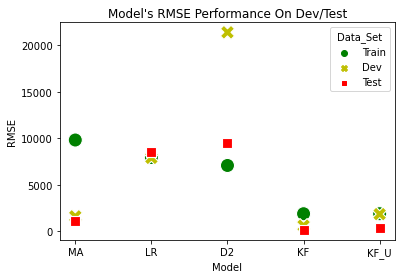

In [133]:
sns.scatterplot(data = Store_100
               ,hue='Data_Set'
               ,style='Data_Set'
               ,x='Model'
               ,y='RMSE'
               ,palette = ['g','y','r'] 
               ,s=200
               ,legend='brief'
               ,alpha=1
)

plt.title("Model's RMSE Performance On Dev/Test")

plt.show()

Above was for one store, now do it for all stores

In [148]:
df = Model_Scores(data,target='Sales',models=[MA_Model,LR_Model,Poly_Regression,KF_Model,KF_Model_U])

Insufficient data for StoreID 13280
Insufficient data for StoreID 13280
Insufficient data for StoreID 13280
Insufficient data for StoreID 13280
Insufficient data for StoreID 13280
Insufficient data for StoreID 13669
Insufficient data for StoreID 13669
Insufficient data for StoreID 13669
Insufficient data for StoreID 13669
Insufficient data for StoreID 13669
Insufficient data for StoreID 14041
Insufficient data for StoreID 14041
Insufficient data for StoreID 14041
Insufficient data for StoreID 14041
Insufficient data for StoreID 14041
Insufficient data for StoreID 14402
Insufficient data for StoreID 14402
Insufficient data for StoreID 14402
Insufficient data for StoreID 14402
Insufficient data for StoreID 14402
Insufficient data for StoreID 14406
Insufficient data for StoreID 14406
Insufficient data for StoreID 14406
Insufficient data for StoreID 14406
Insufficient data for StoreID 14406
Insufficient data for StoreID 15201
Insufficient data for StoreID 15201
Insufficient data for StoreI

In [149]:
df

C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Model,Data_Set,RMSE,Params,StoreID,Run_Time
0,MA,Train,9824.7178,17,100,0.028925
1,MA,Dev,1619.2110,17,100,0.028925
2,MA,Test,1081.5041,17,100,0.028925
3,LR,Train,7945.0436,"{'fit_intercept': True, 'normalize': True, 'co...",100,0.039898
4,LR,Dev,7907.3956,"{'fit_intercept': True, 'normalize': True, 'co...",100,0.039898
...,...,...,...,...,...,...
10390,KF,Dev,1052.2500,,27641,0.036902
10391,KF,Test,509.2910,,27641,0.036902
10392,KF_U,Train,1901.7750,,27641,0.034478
10393,KF_U,Dev,3549.9685,,27641,0.034478


C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


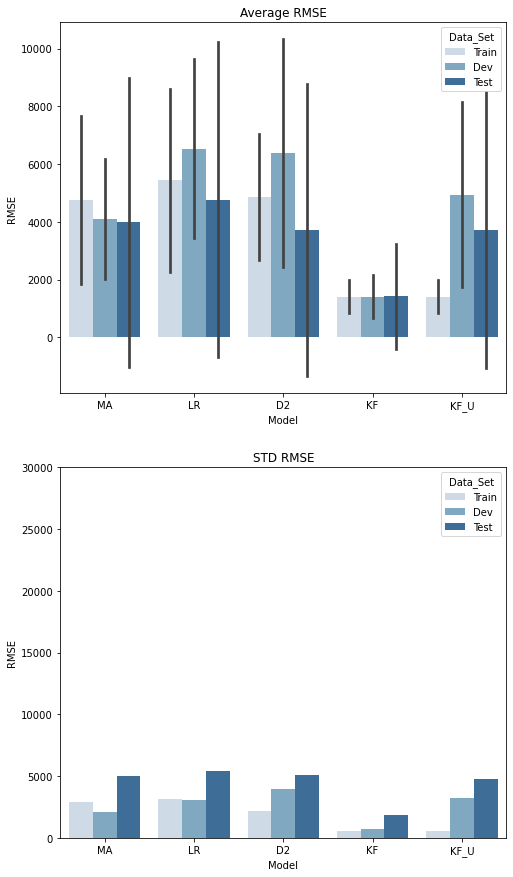

In [150]:
plt.subplot(2,1,1)
#plt.ylim(0,30000)
plt.gcf().set_size_inches(8, 15)
sns.barplot(data=df,y='RMSE',x='Model',hue='Data_Set', saturation=0.6,ci="sd",palette="Blues")

plt.title("Average RMSE")



plt.subplot(2,1,2)

plt.ylim(0,30000)
sns.barplot(data=df,y='RMSE',x='Model',hue='Data_Set', saturation=0.6,ci=None,estimator = np.std,palette="Blues")

plt.title("STD RMSE")


#plt.tight_layout()

plt.show()

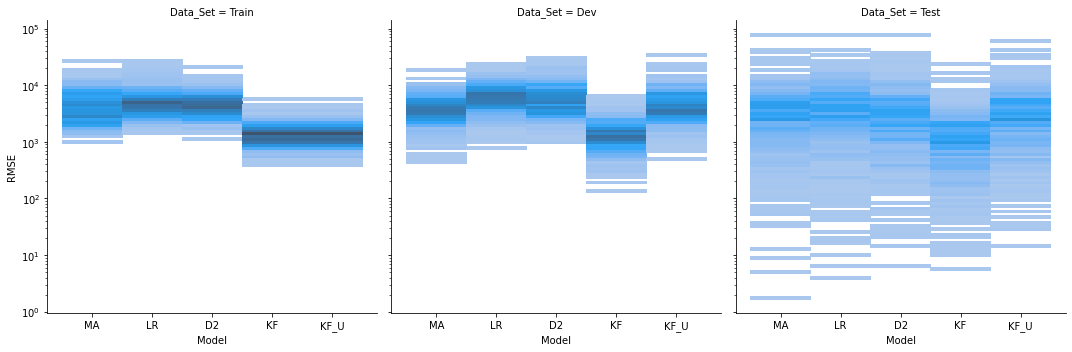

In [152]:
sns.displot(data=df
           ,x='Model'
           ,y='RMSE'
           ,col='Data_Set'
           ,log_scale=(False,True)
           )

C:\Users\TVang\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


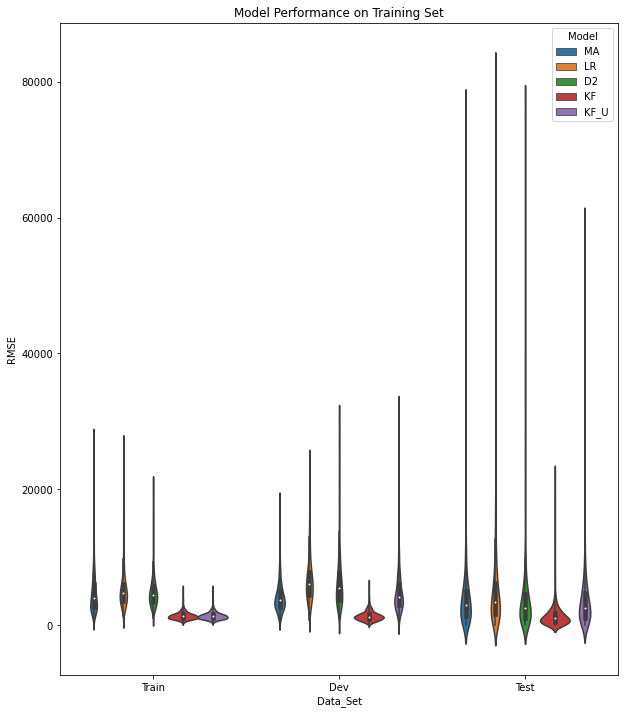

In [155]:

plt.gcf().set_size_inches(10, 12)
sns.violinplot(data=df
              ,x='Data_Set'
              ,y='RMSE'
               ,hue='Model'
              )


plt.title('Model Performance on Training Set')

plt.show()

# Evaluation

Kalman Filter does extremely well, outperforming all other models by far.  Although when not given a known observation, it seems to overfit in the training set and then score similar to the other models in the dev and test sets.

Linear Regression has a pretty consistant prediction across all it's data set, but it's overall the worst scoring one.

The Polynomial Regression does slightly better, but still relatively bad.

Moving average did the worst in the training set, the best in the dev set (disregarding Kalman Filter) and decently in the test set

Besides the Kalman Filter, no one model is doing too great.

The test set has the worst scores

# Future Improvements

Some models seems to be overfitting either the training or dev set.  Perhaps find a way to better predict without overfitting either one

ARIMA is a powerful model for time series, but looping through all the stores and parameters is taking too much time.  I did auto_arima, although it was returning something weird and scoring not well at all.  Perhaps go back and find a way to utilize this model

Explore other models meant for time series